In [22]:
import easyocr
import cv2
from matplotlib import pyplot as plt
from perspective_corrector import PerspectiveCorrector
import pandas as pd
import numpy as np

In [23]:
reader = easyocr.Reader(['en'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [24]:
image = cv2.imread('images/citizee.jpg')

In [25]:
corrector = PerspectiveCorrector(image)
img = corrector.correct_perspective()


In [26]:
h, w = img.shape[:2]
top_40 = int(h*0.4)
img = img[:top_40, :]

In [27]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

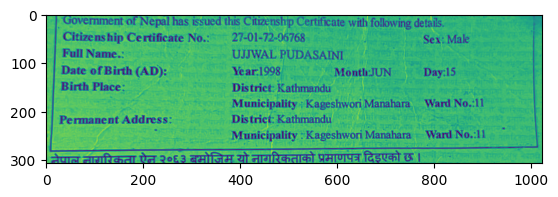

In [28]:
plt.imshow(gray)
plt.show()

In [29]:
fields = ["Citizenship Certificate No.", "Sex", "Full Name", "Year", "Month", "Day", "District","Municipality","Ward No.", "District","Municipality","Ward No."]

key_distances = {
    "Citizenship Certificate No.": (300, 300),
    "Sex":(48, 100),
    "Full Name": (300, 300),
    "Year": (50, 56),  
    "Month": (66, 56),  
    "Day": (47,56),  
    "District": (86, 150), 
    "Municipality": (135, 300),  
    "Ward No": (100, 50)
}
mask =np.zeros_like(gray, dtype=np.uint8)

In [30]:
result_grey = reader.readtext(gray)
print(result_grey)

[([[30, 0], [823, 0], [823, 37], [30, 37]], 'Govemment of Nepal has issued this Citizenshp Certificate with follwing detalls.', 0.5706845981915483), ([[32, 32], [334, 32], [334, 64], [32, 64]], 'Citizenship Certificate No.=', 0.7054339185930657), ([[380, 34], [538, 34], [538, 62], [380, 62]], '27-01-72-06768', 0.7543350344408482), ([[776, 38], [878, 38], [878, 64], [776, 64]], 'Sex : Mak', 0.7282026447539457), ([[30, 66], [158, 66], [158, 94], [30, 94]], 'Full Name._', 0.7030555309410993), ([[379, 68], [620, 68], [620, 100], [379, 100]], 'UJJWAL PUDASAINI', 0.7304310186972314), ([[28, 102], [252, 102], [252, 132], [28, 132]], 'Date of Birth (AD):', 0.4636817183572645), ([[382, 104], [488, 104], [488, 130], [382, 130]], 'Year:1998', 0.5467664755056268), ([[592, 108], [716, 108], [716, 132], [592, 132]], 'Month JUN', 0.6445356722856628), ([[775, 105], [850, 105], [850, 135], [775, 135]], 'Day:IS', 0.4150991437158545), ([[26, 136], [166, 136], [166, 162], [26, 162]], 'Birth Place :', 0.91

In [31]:
df = pd.DataFrame([{
    'x1': item[0][0][0],
    'y1': item[0][0][1],
    'x4': item[0][2][0],
    'y4': item[0][2][1],
    'key': item[1]
} for item in result_grey])

In [32]:
print(df)

     x1   y1   x4   y4                                                key
0    30    0  823   37  Govemment of Nepal has issued this Citizenshp ...
1    32   32  334   64                       Citizenship Certificate No.=
2   380   34  538   62                                     27-01-72-06768
3   776   38  878   64                                          Sex : Mak
4    30   66  158   94                                        Full Name._
5   379   68  620  100                                   UJJWAL PUDASAINI
6    28  102  252  132                                Date of Birth (AD):
7   382  104  488  130                                          Year:1998
8   592  108  716  132                                          Month JUN
9   775  105  850  135                                             Day:IS
10   26  136  166  162                                      Birth Place :
11  382  138  592  166                                District: Kathmandu
12  381  167  520  200                

In [33]:
# for result in result_grey:
#     text = result[1]
#     (x1, y1), (x2, y2), (x3, y3), (x4, y4) = result[0]
#     for key, distance in key_distances.items():
#         if result[1].startswith(key):
#             mask[y1:y4, x1+distance:x1+distance+200] = gray[y1:y4, x1+distance:x1+distance+200]
#             value = reader.readtext(mask)
#             extracted_data = key + ": " + value[1]
# print(extracted_data)

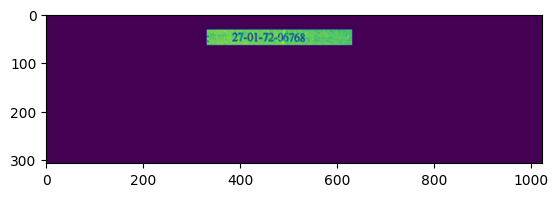

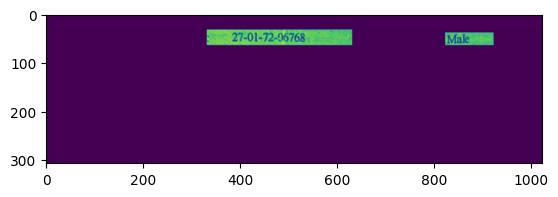

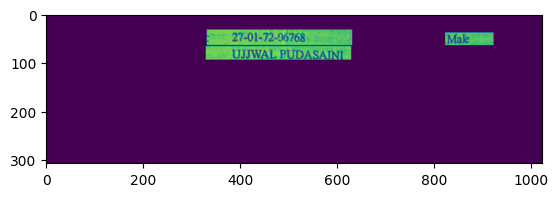

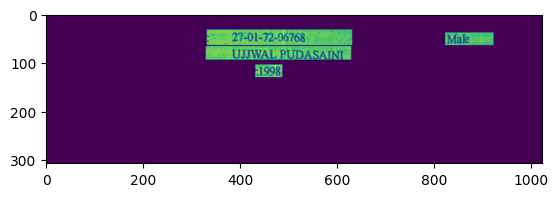

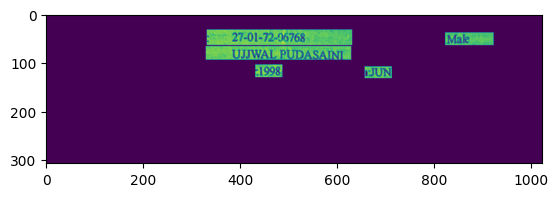

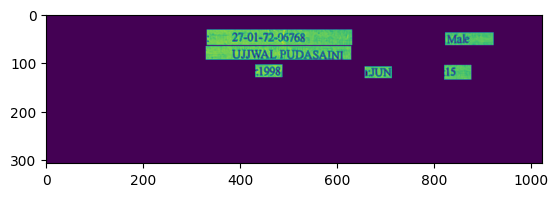

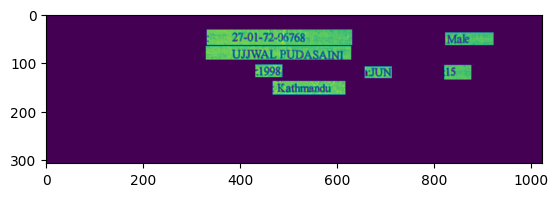

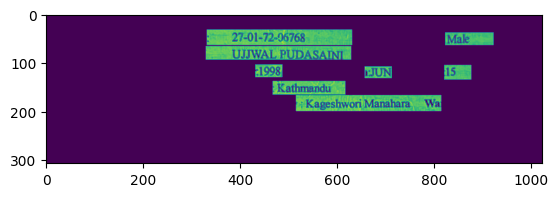

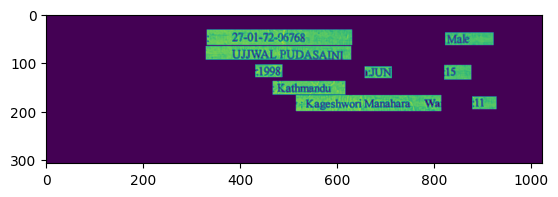

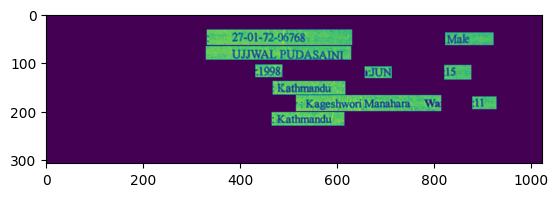

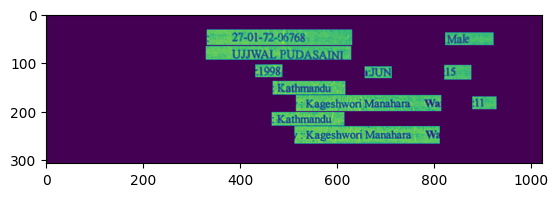

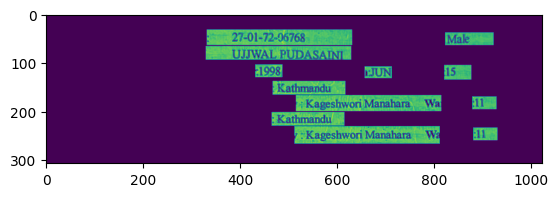

In [34]:
i=0
extracted_data = {}
for result in result_grey:
    text = result[1]
    (x1, y1), (x2, y2), (x3, y3), (x4, y4) = result[0]
    
    for key, (distance1, distance2) in key_distances.items():
        # Check if the text contains the key (part of the key can be in the text)
        if (key in text)|(text in key):
            # Calculate the coordinates for the mask
            x_start = x1 + distance1
            x_end = x_start + distance2
            y_start = y1
            y_end = y4
            
            # Ensure that the slicing does not go out of bounds
            x_start = max(x_start, 0)
            x_end = min(x_end, mask.shape[1])
            y_start = max(y_start, 0)
            y_end = min(y_end, mask.shape[0])
            
            # Apply the mask to the relevant portion
            mask[y_start:y_end, x_start:x_end] = gray[y_start:y_end, x_start:x_end]
            plt.imshow(mask)
            plt.show()
            # Read the text from the masked area
            value = reader.readtext(mask)
            if value:
                data = value[i][1]
                extracted_text = data
                extracted_data[key] = extracted_text.strip()
                i=i+1
            break  # Stop after processing the first matching key

In [35]:
print(extracted_data)

{'Citizenship Certificate No.': '27-01-72-06768', 'Sex': 'Mak', 'Full Name': 'UJWAL PUDASANNL', 'Year': '1l998', 'Month': 'EJUN', 'Day': 'J5', 'District': 'Kathmandu', 'Municipality': 'Kageshwori Manahara', 'Ward No': 'Wa'}
